In [ ]:
# Copyright 2022 Google LLC
#
# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
#     https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

<table align="left">

  <td>
    <a href="https://github.com/GoogleCloudPlatform/vertex-ai-samples/blob/main/notebooks/official/workbench/spark/spark_sample_notebook.ipynb">
      <img src="https://cloud.google.com/ml-engine/images/github-logo-32px.png" alt="GitHub logo">
      View on GitHub
    </a>
  </td>
  <td>
    <a href="https://console.cloud.google.com/vertex-ai/workbench/deploy-managed-notebook?download_url=https://raw.githubusercontent.com/GoogleCloudPlatform/vertex-ai-samples/main/notebooks/official/workbench/spark/spark_bigquery.ipynb">
      <img src="https://lh3.googleusercontent.com/UiNooY4LUgW_oTvpsNhPpQzsstV5W8F7rYgxgGBD85cWJoLmrOzhVs_ksK_vgx40SHs7jCqkTkCk=e14-rj-sc0xffffff-h130-w32" alt="Vertex AI logo">
      Open in Vertex AI Workbench
    </a>
  </td>                                                                                               
</table>

## Overview

This notebook tutorial shows you how to ingest, analyze, and write data to BigQuery using Apache Spark with [Dataproc](https://cloud.google.com/dataproc). The notebook code analyzes GitHub Activity Data to explore metrics related to programming languages used in GitHub repositories.

To run this notebook, click the link `Open in Vertex AI Workbench` above.

### Dataset

The [GitHub Activity Data](https://console.cloud.google.com/marketplace/product/github/github-repos) dataset is available in [BigQuery Public Datasets](https://cloud.google.com/bigquery/public-data), and provides free querying of up to 1TB of data each month. It contains data on two different types of repositories: "polyglot" repos, which support multiple programming language files, and "monoglot" repos, which support one programming language.

### Objective

This notebook tutorial runs an Apache Spark job that fetches data from the BigQuery "GitHub Activity Data" dataset, queries the data, and then writes the results back to BigQuery. This job sequence represents a common data engineering use case: ingesting, transforming, and querying data, and then writing the output to a database. It also demonstrates how to submit an Apache Spark job to Dataproc.

This notebook tutorial performs the following steps:

- Setting up a Google Cloud project and Dataproc cluster.
- Configuring the spark-bigquery-connector.
- Ingesting data from BigQuery into a Spark DataFrame.
- Preprocessing ingested data.
- Querying the most frequently used programming language in monoglot repos.
- Querying the average size (MB) of code in each language stored in monoglot repos.
- Querying the languages files most frequently found together in polyglot repos.
- Writing the query results back into BigQuery.
- Deleting the resources created for this notebook tutorial.

### Costs 

This tutorial uses billable components of Google Cloud:

* [Vertex AI](https://cloud.google.com/vertex-ai/pricing)
* [Cloud Storage](https://cloud.google.com/storage/pricing)
* [Dataproc](https://cloud.google.com/dataproc/pricing)

You can use the [Pricing Calculator](https://cloud.google.com/products/calculator/) to generate a cost estimate based on your projected usage.

## Before you begin

### Set up your Google Cloud project:

1. [Select or create a Google Cloud project](https://console.cloud.google.com/cloud-resource-manager). When you create an account, you receive a $300 credit towards to your compute and storage costs.

1. [Make sure that billing is enabled for your project](https://cloud.google.com/billing/docs/how-to/modify-project).

1. [Enable the Notebooks API, Vertex AI API, and Dataproc API](https://console.cloud.google.com/flows/enableapi?apiid=notebooks.googleapis.com,aiplatform.googleapis.com,dataproc&_ga=2.209429842.1903825585.1657549521-326108178.1655322249)

**Note**: Jupyter runs lines prefixed with `!` as shell commands, and inserts the value of Python variables prefixed with `$` into the commands.

### Installation

Install the following packages to run this notebook.

In [1]:
import os

# The Google Cloud Notebook product has specific requirements
IS_GOOGLE_CLOUD_NOTEBOOK = os.path.exists("/opt/deeplearning/metadata/env_version")

USER_FLAG = ""
# Google Cloud Notebook requires dependencies to be installed with '--user'
if IS_GOOGLE_CLOUD_NOTEBOOK:
    USER_FLAG = "--user"

Since the test environment does not have Java and PySpark, the following cell is necessary for the testing purpose.

In [2]:
if os.getenv("IS_TESTING"):
    """
    The testing suite does not currently support testing on Dataproc clusters,
    so the testing environment is setup to replicate Dataproc via the following steps.
    """
    JAVA_VER = "8u332-b09"
    JAVA_FOLDER = "/tmp/java"
    FILE_NAME = f"openlogic-openjdk-{JAVA_VER}-linux-x64"
    TAR_FILE = f"{JAVA_FOLDER}/{FILE_NAME}.tar.gz"
    DOWNLOAD_LINK = f"https://builds.openlogic.com/downloadJDK/openlogic-openjdk/{JAVA_VER}/openlogic-openjdk-{JAVA_VER}-linux-x64.tar.gz"
    PYSPARK_VER = "3.1.3"

    # Download Open JDK 8. Spark requires Java to execute.
    ! rm -rf $JAVA_FOLDER
    ! mkdir $JAVA_FOLDER
    ! wget -P $JAVA_FOLDER $DOWNLOAD_LINK
    os.environ["JAVA_HOME"] = f"{JAVA_FOLDER}/{FILE_NAME}"
    ! tar -zxf $TAR_FILE -C $JAVA_FOLDER
    ! echo $JAVA_HOME

    # Pin the Spark version to match that the Dataproc 2.0 cluster.
    ! pip install {USER_FLAG} pyspark==$PYSPARK_VER -q

### Create a Dataproc cluster

The Spark job executed in this notebook tutorial is compute intensive. Since the job can take a significant amount time to complete in a standard notebook environment, this notebook tutorial runs on a Dataproc cluster that is created with the Dataproc Component Gateway and Jupyter component installed on the cluster.

**Existing Dataproc with Jupyter cluster?**: If you have a running Dataproc cluster that has the [Component Gateway and Jupyter component installed on the cluster](https://cloud.google.com/dataproc/docs/concepts/components/jupyter#gcloud-command), you can use it in this tutorial. If you plan to use it, skip this step, and go to `Switch your kernel`.

In [9]:
if not os.getenv("IS_TESTING"):
    CLUSTER_NAME = "my-spark-cluster-04"  # @param {type: "string"}
    CLUSTER_REGION = "[your-region]"  # @param {type: "string"}

    if CLUSTER_REGION == "[your-region]":
        CLUSTER_REGION = "us-central1"

    print(f"CLUSTER_NAME: {CLUSTER_NAME}")
    print(f"CLUSTER_REGION: {CLUSTER_REGION}")

CLUSTER_NAME: my-spark-cluster-04
CLUSTER_REGION: us-central1


In [10]:
if not os.getenv("IS_TESTING"):
    !gcloud dataproc clusters create $CLUSTER_NAME \
        --region=$CLUSTER_REGION \
        --enable-component-gateway \
        --image-version=2.0 \
        --subnet spark-snet \
        --optional-components=JUPYTER

Waiting on operation [projects/dataproc-demo-praj/regions/us-central1/operations/3f55208f-e690-39bd-a796-b95c121b7432].
Waiting for cluster creation operation...done.                                 
Created [https://dataproc.googleapis.com/v1/projects/dataproc-demo-praj/regions/us-central1/clusters/my-spark-cluster-04] Cluster placed in zone [us-central1-a].


Your `CLUSTER_NAME` must be **unique within your Google Cloud project**. It must start with a lowercase letter, followed by up to 51 lowercase letters, numbers, and hyphens, and cannot end with a hyphen.

#### Switch your kernel

Your notebook kernel is listed at the top of the notebook page. Your notebook should run on the Python 3 kernel running on your Dataproc cluster.

Select **Kernel > Change Kernel** from the top menu, then select `Python 3 on CLUSTER_NAME: Dataproc cluster in REGION (Remote)`.

### Set your project ID

Run the following cell to get you project ID.

In [1]:
import os

PROJECT_ID = ""

# Get your Google Cloud project ID from gcloud
if not os.getenv("IS_TESTING"):
    shell_output = !gcloud config list --format 'value(core.project)' 2>/dev/null
    PROJECT_ID = shell_output[0]
    print("Project ID: ", PROJECT_ID)

Project ID:  dataproc-demo-praj


If the previous command has no output, copy your project ID from the project selector in the [Google Cloud console](https://console.cloud.google.com/). Insert the ID in the `[your-project-id]` placeholder, then run the following command.

In [2]:
if PROJECT_ID == "" or PROJECT_ID is None:
    PROJECT_ID = "[your-project-id]"  # @param {type: "string"}

In [3]:
PROJECT_ID

'dataproc-demo-praj'

In [ ]:
! gcloud config set project $PROJECT_ID -q

### Create a Bigquery Dataset

The Spark DataFrame created in this tutorial is stored in BigQuery.

#### UUID

To avoid name collisions, you can create a UUID for the current notebook session, then append the UUID to the BigQuery dataset that you create in this tutorial.

In [4]:
import random
import string


# Generate a uuid of a specifed length(default=8)
def generate_uuid(length: int = 8) -> str:
    return "".join(random.choices(string.ascii_lowercase + string.digits, k=length))


UUID = generate_uuid()

In [5]:
UUID

'7o8io3ou'

Set the name of your BigQuery dataset, then create it.

In [6]:
if not os.getenv("IS_TESTING"):
    DATASET_NAME = "spark_dataset"  # @param {type:"string"}

    if (
        DATASET_NAME == ""
        or DATASET_NAME is None
        or DATASET_NAME == "[your-dataset-name]"
    ):
        DATASET_NAME = f"{PROJECT_ID}{UUID}"
else:
    DATASET_NAME = f"python_docs_samples_tests_spark_{UUID}"

In [7]:
! bq mk $DATASET_NAME

Dataset 'dataproc-demo-praj:spark_dataset' successfully created.


## Tutorial

### Import required libraries

In [8]:
# You use Spark SQL in a "SparkSession" to create DataFrames
from pyspark.sql import SparkSession
# PySpark functions
from pyspark.sql.functions import avg, col, count, desc, round, size, udf
# These allow us to create a schema for our data
from pyspark.sql.types import ArrayType, IntegerType, StringType

### Initialize the SparkSession

To use Apache Spark with BigQuery, you must include the [spark-bigquery-connector](https://github.com/GoogleCloudDataproc/spark-bigquery-connector) when you initialize the `SparkSession`.

In [9]:
# Initialize the "SparkSession" with the following config.
VER = "0.26.0"
FILE_NAME = f"spark-bigquery-with-dependencies_2.12-{VER}.jar"

if os.getenv("IS_TESTING"):
    connector = f"https://github.com/GoogleCloudDataproc/spark-bigquery-connector/releases/download/{VER}/{FILE_NAME}"
else:
    connector = f"gs://spark-lib/bigquery/{FILE_NAME}"

spark = (
    SparkSession.builder.appName("spark-bigquery-polyglot-language-demo")
    .config("spark.jars", connector)
    .config("spark.sql.debug.maxToStringFields", "500")
    .getOrCreate()
)

Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
22/08/20 17:59:42 INFO org.apache.spark.SparkEnv: Registering MapOutputTracker
22/08/20 17:59:42 INFO org.apache.spark.SparkEnv: Registering BlockManagerMaster
22/08/20 17:59:42 INFO org.apache.spark.SparkEnv: Registering BlockManagerMasterHeartbeat
22/08/20 17:59:42 INFO org.apache.spark.SparkEnv: Registering OutputCommitCoordinator


### Fetch data from BigQuery

In [10]:
# Load the Github Activity public dataset from BigQuery.
df = (
    spark.read.format("bigquery")
    .option("table", "bigquery-public-data.github_repos.languages")
    .load()
)

# Restrict testing data since the testing environment runs on a small Docker image.
if os.getenv("IS_TESTING"):
    df = df.sample(0.0001)

df.printSchema()

root
 |-- repo_name: string (nullable = true)
 |-- language: array (nullable = true)
 |    |-- element: struct (containsNull = true)
 |    |    |-- name: string (nullable = true)
 |    |    |-- bytes: long (nullable = true)



### Preprocessing

As shown in the displayed schema, Github Activity data is stored in arrays, not in primitive types. 

To work effectively with data, convert the arrays to primitive types, and separate the monoglot and polyglot repo data.

The return type of three Python functions have an `@udf` annotation (signifying a [User Defined Function](https://spark.apache.org/docs/3.1.3/api/python/reference/api/pyspark.sql.functions.udf.html)). UDFs extend PySpark framework functions.

In [11]:
# Set the LIMIT constant as 10 to get the top ten results.
LIMIT = 10

# A constant used to explode the pie chart to aid visibility.
EXPLODE_PIE_CHART = tuple([0.05] * LIMIT)


@udf(returnType=StringType())
def language_to_mono_language(language) -> str:
    """
    The preprocessing function takes a language array and returns its name if the language has one element.
    Args:
        language: list of struct that contains name and bytes.
                  (e.g., language = [[name: "C", bytes: 300]]
    Returns:
        Monorepo's name
    """
    return language[0].name if len(language) == 1 else None


@udf(returnType=IntegerType())
def language_to_mono_size(language) -> int:
    """
    The preprocessing function takes a language array and returns its bytes if the language has one element.
    Args:
        language: list of struct that contains name and bytes.
                  (e.g., language = [[name: "C", bytes: 300]]
    Returns:
        Monorepo's bytes
    """
    return language[0].bytes if len(language) == 1 else 0


@udf(returnType=StringType())
def language_to_poly_language(language) -> str:
    """
    The preprocessing function takes a language array and returns the top three language names based on their bytes.
    Args:
        language: list of struct that contains name and bytes.
                  (e.g., language = [[name: "C", bytes: 300],
                                     [name: "Java", bytes: 200]]
    Returns:
        Polyrepo's name in string form separated by commas
    """
    if len(language) < 2:
        return None
    # Sort languages by their bytes in a descending order.
    language.sort(key=lambda x: -x.bytes)
    top_3 = language[:3]

    # Sort top_3 languages by their name.
    top_3.sort(key=lambda x: x.name)
    ret = []
    for elem in top_3:
        ret.append(elem.name)
    return ", ".join(ret)

In [12]:
# Create a DataFrame named "preprocessed_df", with the array split into three columns using UDF.
preprocessed_df = df.select(
    col("repo_name"),
    language_to_mono_language(col("language")).alias("mono_language"),
    language_to_mono_size(col("language")).alias("mono_size"),
    language_to_poly_language(col("language")).alias("poly_language"),
)
preprocessed_df.printSchema()

root
 |-- repo_name: string (nullable = true)
 |-- mono_language: string (nullable = true)
 |-- mono_size: integer (nullable = true)
 |-- poly_language: string (nullable = true)



The displayed `preprocessed_df`'s schema shows the language column separated into three columns: `mono_language`, `mono_size`, and `poly_language`.

In [13]:
# Output the number of repositories of monoglot(single language used) and polyglot(multiple languages used).
mono = preprocessed_df.where(col("mono_language").isNotNull()).count()
print(f"The number of repositories that use one language is {mono}")

poly = preprocessed_df.where(col("poly_language").isNotNull()).count()
print(f"The number of repositories that use multiple languages is {poly}")

poly_percent = (poly / (mono + poly)) * 100
print(
    f"Polyglot repositories comprise approximately {poly_percent:.2f}% of the total number of repositories."
)

The number of repositories that use one language is 1203249


The number of repositories that use multiple languages is 1752842
Polyglot repositories comprise approximately 59.30% of the total number of repositories.


### Analyze

#### What language is most frequently used in the monoglot repos?
To answer this question, execute the following query with the preprocessed column, `mono_language`.

In [14]:
# Get the monoglot repositories and sort them based on language popularity.
mono_ranking = (
    preprocessed_df.groupBy("mono_language")
    .count()
    .sort(desc("count"))
    .where(col("mono_language").isNotNull())
)
mono_ranking.show()

+-------------+------+
|mono_language| count|
+-------------+------+
|   JavaScript|203844|
|       Python|191093|
|         Java|183307|
|         Ruby|106317|
|          PHP| 96062|
|           C#| 57748|
|        Shell| 56158|
|           Go| 42835|
|  Objective-C| 22480|
|          C++| 21970|
|         HTML| 20715|
|            C| 16382|
|      Haskell| 15999|
|      Clojure| 12224|
|        Swift| 10897|
|        Scala| 10755|
|          CSS| 10610|
|            R|  9035|
|         Perl|  8877|
|         Rust|  8331|
+-------------+------+
only showing top 20 rows



Using `mono_ranking`, visualize the results with a pie chart.

<AxesSubplot:title={'center':'Monoglot repositories'}>

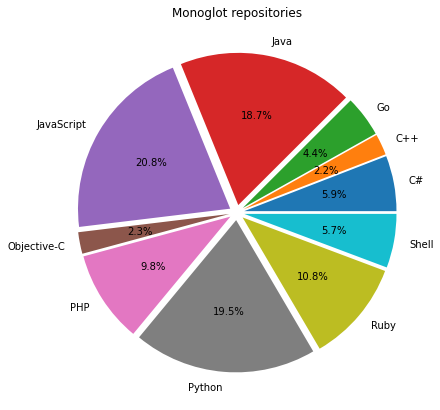

In [15]:
# Convert the Spark DataFrame to a Pandas DataFrame to display the pie chart.
mono_panda = mono_ranking.toPandas()[:LIMIT].copy()
mono_panda.groupby(["mono_language"]).sum().plot(
    kind="pie",
    y="count",
    autopct="%1.1f%%",
    label="",
    title="Monoglot repositories",
    legend=False,
    figsize=(7, 7),
    explode=EXPLODE_PIE_CHART,
)

#### What is the average size of each language in the monoglot repos?

Preprocessed the `mono_size` and `mono_language` columns to get the average size of each language.

`mono_size` bytes are stated in kilobytes. The following query divides `mono_size` by 1000 to convert the size to megabytes.

In [16]:
mono_ranking_avg_bytes = (
    preprocessed_df.groupBy("mono_language")
    .agg(
        count("mono_language").alias("count"),
        round(avg("mono_size") / 1000).alias("average_in_MB"),
    )
    .sort(desc("average_in_MB"))
    .where(col("mono_language").isNotNull() & (col("count") > 500))
)

mono_ranking_avg_bytes.show()

+----------------+------+-------------+
|   mono_language| count|average_in_MB|
+----------------+------+-------------+
|Jupyter Notebook|  2544|       2225.0|
|            HTML| 20715|        359.0|
|          Pascal|  1264|        358.0|
|              C#| 57748|        225.0|
|    ActionScript|  1421|        224.0|
|    Visual Basic|  2302|        217.0|
|             Lua|  7889|        175.0|
|        Assembly|   763|        165.0|
|            Java|183307|        152.0|
|             TeX|  3403|        127.0|
|            Haxe|   932|        103.0|
|             PHP| 96062|         91.0|
|      Emacs Lisp|  2708|         86.0|
|          Matlab|  4303|         83.0|
|     Common Lisp|  1999|         80.0|
|               D|   885|         78.0|
|               R|  9035|         75.0|
|            Perl|  8877|         73.0|
|            Dart|  1612|         73.0|
|      PowerShell|  4598|         73.0|
+----------------+------+-------------+
only showing top 20 rows



#### What three languages are most frequently found together in polyglot repos?

Using the preprocessed `poly_language` column, implement a query to show the ranking of polyglot repositories with the top 3 languages based on size.

In [17]:
# Get the polyglot repositories by language popularity.
poly_ranking = (
    preprocessed_df.groupBy("poly_language")
    .count()
    .sort(desc("count"))
    .where(col("poly_language").isNotNull())
)

poly_ranking.show()

+--------------------+------+
|       poly_language| count|
+--------------------+------+
|CSS, HTML, JavaSc...|250520|
|CSS, JavaScript, PHP| 71304|
|     CSS, JavaScript| 60467|
|    HTML, JavaScript| 53482|
|       Python, Shell| 33743|
|           CSS, HTML| 26872|
|     CSS, HTML, Ruby| 24970|
|HTML, JavaScript,...| 22134|
|   Objective-C, Ruby| 21527|
|HTML, JavaScript,...| 19856|
|         Ruby, Shell| 19755|
|CSS, JavaScript, ...| 18009|
|CSS, JavaScript, ...| 16882|
|    Assembly, C, C++| 14928|
|              C, C++| 13918|
|      CSS, HTML, PHP| 13044|
|CSS, Java, JavaSc...| 13025|
|      C, C++, Python| 12883|
|   CSS, HTML, Python| 12723|
|         Java, Shell| 11955|
+--------------------+------+
only showing top 20 rows



The majority of results contain a combination of HTML or CSS, and Javascript.

Display a pie chart:

<AxesSubplot:title={'center':'Polyglot repositories'}>

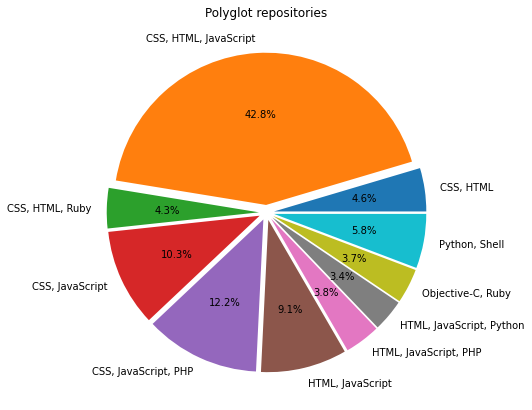

In [18]:
# Convert the Spark DataFrame to a Pandas DataFrame to display the pie chart.
poly_panda = poly_ranking.toPandas()[:LIMIT].copy()
poly_panda.groupby(["poly_language"]).sum().plot(
    kind="pie",
    y="count",
    autopct="%1.1f%%",
    label="",
    title="Polyglot repositories",
    legend=False,
    figsize=(7, 7),
    explode=EXPLODE_PIE_CHART,
)

The pie chart shows that eight out of the top ten results contain either `HTML` or `CSS`.

You can create combinations of languages in each repo using the original data fetched from BigQuery.

In [19]:
# A Python package to get combinations.
from itertools import combinations
# A Python package to use type hint
from typing import List

# PySpark functions
from pyspark.sql.functions import explode

In [20]:
def normalize_name(name: str) -> str:
    """
    Change the language name to avoid invalid characters in the BigQuery data.
    Args:
        name: string
    Returns:
        Normalized name: string
    """
    normalized_arr = []

    # The following sets of characters cannot be used in BigQuery's fields.
    invalid_chars = {",", ";", "{", "}", "(", ")", "\n", "\t", "=", "'"}
    replace_chars = {
        " ": "_",
        ".": "_",
        "-": "_",
        "#": "_sharp",
        "+": "_plus",
        "*": "_star",
    }

    # The name must start with a letter or underscore.
    if name[0].isnumeric():
        normalized_arr.append("_")

    for ch in name:
        # Skip if a character is in the set of invalid characters.
        if ch in invalid_chars:
            continue

        # Replace if a character is in the dictionary of replace_chars.
        if ch in replace_chars:
            normalized_arr.append(replace_chars[ch])

        # Change to lowercase to merge name duplications, for example, "Java" and "java".
        else:
            normalized_arr.append(ch.lower())

    # Convert the array to string
    return "".join(normalized_arr)


@udf(returnType=ArrayType(StringType()))
def reduce_language(language) -> List[str]:
    """
    The preprocess function takes the language and reduces it to remove "bytes".
    Args:
        language: list of struct that contains name and bytes.
                  (e.g., language = [[name: "C", bytes: 300],
                                     [name: "Java", bytes: 200]]
    Returns:
        list of strings that contains name.
                  (e.g., reduced_languages = ["C", "Java"])
    """
    if len(language) < 2:
        return None
    reduced_languages = []
    for elem in language:
        # To write back to BigQuery, the name must be normalized.
        normalized_name = normalize_name(elem.name)
        reduced_languages.append(normalized_name)
    return reduced_languages


@udf(returnType=ArrayType(ArrayType(StringType())))
def preprocess_combination(language) -> List[List[str]]:
    """
    The preprocess function takes the language and returns every language combination.
    Args:
        language: list of struct that contains name and bytes.
                  (e.g., language = [[name: "C", bytes: 300],
                                     [name: "Java", bytes: 200]]
    Returns:
        List of every possible combinations.
                  (e.g., arr_combinations = [["C", "Java"], ["Java", "C"]])
    """
    if not language:
        return None
    arr_combinations = []
    for combination in combinations(language, 2):
        arr_combinations.append(combination)
        arr_combinations.append(combination[::-1])
    return arr_combinations


# Preprocess the "reduced_languages" column using UDF.
df = df.withColumn("reduced_languages", reduce_language(col("language")))

# Preprocess the "combinations" column using UDF.
df = df.withColumn("combinations", preprocess_combination(col("reduced_languages")))

# Create another DataFrame from "df" that has "repo_name" and "combinations" as columns.
frequency_df = df.select(col("repo_name"), col("combinations")).where(
    size(col("language")) > 1
)
frequency_df.printSchema()

root
 |-- repo_name: string (nullable = true)
 |-- combinations: array (nullable = true)
 |    |-- element: array (containsNull = true)
 |    |    |-- element: string (containsNull = true)



`frequency_df` has the repo name and combinations of languages.

Use the Spark `explode()` function, which is similar to the SQL `UNNEST` function.

Your table currently has the following content:

| repo_name   | combinations      |
| :----------: | :---------------: |
| a           | [['C', 'C++'], ['C++', 'C'], ['C', 'Java'], ['Java', 'C’], ['C++', 'Java'], ['Java', 'C++']]|
| b           | [['C', 'C++'], ['C++', 'C'], ['C', 'Python'], ['Python', 'C'], ['C++', 'Python'], ['Python', 'C++']]|

In [21]:
# explode() converts the elements in combinations to rows.
frequency_df = frequency_df.withColumn("languages", explode(col("combinations")))

# Create columns for combinations of languages.
frequency_df = frequency_df.withColumn("language0", col("languages")[0])
frequency_df = frequency_df.withColumn("language1", col("languages")[1])

After using `explode()` and adding the `langauge0` and `language1` columns, the `frequency_df` table has the following content:

| repo_name   | languages         | language0    | language1 |
| :---------: | :---------------: | :--------:   | :-------: |
| a           | ['C', 'C++']      | 'C'          |'C++'      |
| a           | ['C++', 'C']      | 'C++'        |'C'        |
| a           | ['C', 'Java']     | 'C'          |'Java'     |
| a           | ['Java', 'C’]     | 'Java'       |'C'        |
| a           | ['C++', 'Java']   | 'C++'        |'Java'     |
| a           | ['Java', 'C++']   | 'Java'       |'C++'      |
| b           | ['C', 'C++']      | 'C'          |'C++'      |
| b           | ['C++', 'C']      | 'C++'        |'C'        |
| b           | ['C', 'Python']   | 'C'          |'Python'   |
| b           | ['Python', 'C']   | 'Python'     |'C'        |
| b           | ['C++', 'Python'] | 'C++'        |'Python'   |
| b           | ['Python', 'C++'] | 'Python'     |'C++'      |

Calculate a pair-wise frequency table of the `language0` and `language1` columns. The first column of each row will contain distinct values of `language0`, and column names will contain distinct values of `language1`.

In [22]:
# crosstab() reshapes the table into a frequency distribution table by using cross tabulations.
frequency_df = frequency_df.crosstab("language0", "language1").withColumnRenamed(
    "language0_language1", "languages"
)

After applying `crosstab()` to `frequency_df`, the DataFrame data is arranged as follows:

| languages  |  C  | C++ | Java | Python |
| :--------: | :-: | :-: | :-:  |  :-:   |
|     C      |  0  |  2  |  1   |   1    |
|     C++    |  2  |  0  |  1   |   1    |
|    Java    |  1  |  1  |  0   |   0    |
|   Python   |  1  |  1  |  0   |   0    |

Note that this table contains sample, not real, data.

See [frequency distribution](https://en.wikipedia.org/wiki/Frequency_%28statistics%29#Frequency_distribution_table) and [cross tabulations](https://en.wikipedia.org/wiki/Contingency_table).

The DataFrame now contains the frequency of each language. Visualize it with a popular language.

In [23]:
# Set of popular languages. You can modify this set to show your preferred languages.
MAJOR_LANGUAGES = {"C", "Java", "Python", "JavaScript", "Go"}

# Declare a dictionary to store the key as a language name and the value as the selected DataFrame
df_dict = dict()

for language in MAJOR_LANGUAGES:
    # Get a top ten languages of each language and store it to the dictionary.
    df_dict[language] = (
        frequency_df.select(col("languages"), language).sort(-col(language)).limit(10)
    )

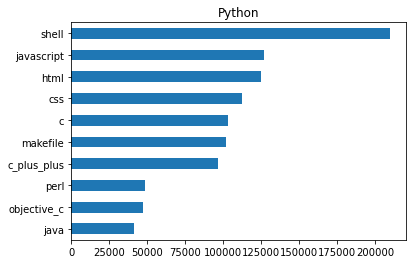

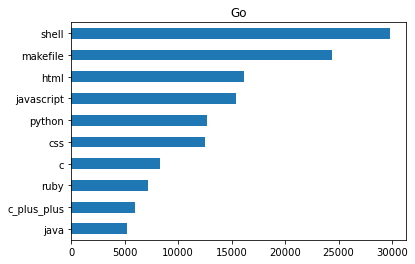

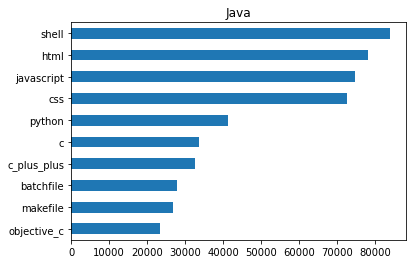

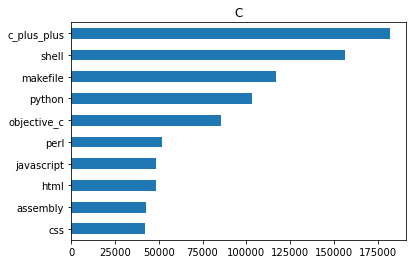

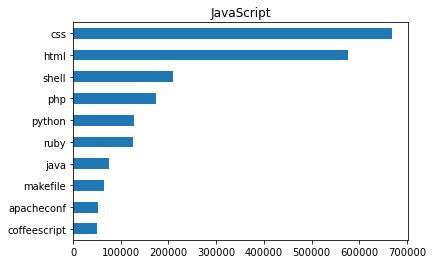

In [24]:
for language in df_dict:
    # Convert Spark DataFrame to Pandas DataFrame to display the bar chart.
    elem_panda = df_dict[language].toPandas()[:LIMIT].copy()
    elem_panda.set_index("languages", inplace=True)
    elem_panda.sort_values(language, ascending=True, inplace=True)
    elem_panda.plot(
        kind="barh",
        title=language,
        legend=False,
        xlabel="",
    )

### Write back to BigQuery

After analyzing these queries, there are several DataFrames: the ranking of monoglot repositories, the average bytes of monoglot repositories, and the frequency table of each language used in a repository. 

These DataFrames will be stored in BigQuery using the [spark-bigquery-connector](https://github.com/GoogleCloudDataproc/spark-bigquery-connector).

In [25]:
dataframes = {
    "mono_ranking": mono_ranking,
}
if not os.getenv("IS_TESTING"):
    dataframes["mono_ranking_avg_bytes"] = mono_ranking_avg_bytes
    dataframes["frequency_table"] = frequency_df

# Iterate through the DataFrames and save them to the BigQuery.
for df in dataframes:
    dataframes[df].write.format("bigquery").option("writeMethod", "direct").option(
        "table", f"{DATASET_NAME}.{df}"
    ).save()

If no errors are reported, Congratulations! Your DataFrame is successfully stored in BigQuery.

You can view the data in the [Google Cloud console](https://console.corp.google.com/bigquery) or using the `bq` command-line tool.

In [26]:
QUERY = f"SELECT languages, python FROM {PROJECT_ID}.{DATASET_NAME}.frequency_table ORDER BY python DESC LIMIT 10"

! bq query --nouse_legacy_sql $QUERY

+-------------+--------+
|  languages  | python |
+-------------+--------+
| shell       | 209973 |
| javascript  | 127093 |
| html        | 124685 |
| css         | 112804 |
| c           | 103339 |
| makefile    | 101675 |
| c_plus_plus |  96640 |
| perl        |  48507 |
| objective_c |  47481 |
| java        |  41387 |
+-------------+--------+


## Cleaning up

See [Clean up](https://cloud.google.com/vertex-ai/docs/workbench/managed/create-managed-notebooks-instance-console-quickstart#clean-up) to delete your project or the managed notebook created in this tutorial.

### Delete BigQuery dataset

In [ ]:
! bq rm -r -f $DATASET_NAME

After you delete the BigQuery dataset, you can check your Datasets in BigQuery using the following command.

In [ ]:
! bq ls

### Delete Dataproc Cluster

It is not possible to delete the cluster you are currently using unless you switch the kernel to local. To delete it, you need to switch the kernel to local `Python 3` or `PySpark`, set your `CLUSTER_NAME` and `CLUSTER_REGION` manually in the following cell, and execute the `gcloud` command.

See [Deleting a cluster](https://cloud.google.com/dataproc/docs/guides/manage-cluster#console) to delete the Dataproc cluster created in this tutorial.

In [ ]:
CLUSTER_NAME = "my-spark-cluster-04"
CLUSTER_REGION = "us-central1"

In [ ]:
if not os.getenv("IS_TESTING"):
    ! gcloud dataproc clusters delete $CLUSTER_NAME --region=$CLUSTER_REGION -q